In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from macro import get_neighbour_sum_matrix_conv, calcEnergy, calcMag
import csv
from pathlib import Path

2023-09-27 07:32:06.819811: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-27 07:32:06.867861: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-27 07:32:08.072597: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Simulation of Ising Model on 2D lattice
This notebook presents the data generated using the Monte Carlo method.<br>
## Metropolis Alghoritm
<strong>In each simulation</strong>:
 
 - A 64x64 lattice was initialzied with random spin configurations.
 - Then, 500 iterations were performed of following alghorithm:<br>
 a) Lattice indices indices were placed in random order<br>
 b) For each spin in the list of indices current energy of the spin and it's fliped version were calculated<br>
 b) It was decided based on the resulting energy difference $\Delta E$ whenever to filp the spin or not: <br>
    if $\Delta E$ < 0 then new spin value was saved<br>
    if $\Delta E$ > 0 then new spin value had probability of $e^{-(\Delta E)/T}$ of being saved<br>
 - The final spin configurations, as well as energy and magnetization for each iteration step, were saved.

In [2]:
def time_series(folder):
    try:
        folder_path = Path(folder)
        reader = csv.DictReader(open(folder_path / "parameters.csv"))
        par_dict = next(reader) 
    except:
        raise ValueError("Invalid folder provided")

    n_rows = int(par_dict['Simulatiton Number'])

    fig = plt.figure(constrained_layout=True, figsize=(20, 20))
    fig.suptitle(f"Temperature: {par_dict['Temperature']} External Field: {par_dict['Magnetic Field']}", fontsize=18)

    subfigs = fig.subfigures(nrows=n_rows, ncols=1)

    for index, subfig in enumerate(subfigs):
        subfig.suptitle(f'Simulation number: {index}')
        data = np.load(folder_path / f"output{index+1}" / "final.npy")

        axs = subfig.subplots(nrows=1, ncols=3)

        axs[0].imshow(data)
        axs[0].set_title(f'Maze')

        columns = ['iter','energy','mag']
        df = pd.read_csv(folder_path / f"output{index+1}" / "data.csv", header=None, names=columns).set_index('iter')

        axs[1].plot(df.energy)
        axs[1].set_title(f'Energy')

        axs[2].plot(df.mag)
        axs[2].set_title(f'Magnetization')

## Low Temperature
Low equilibrium energy, long time of relaxation

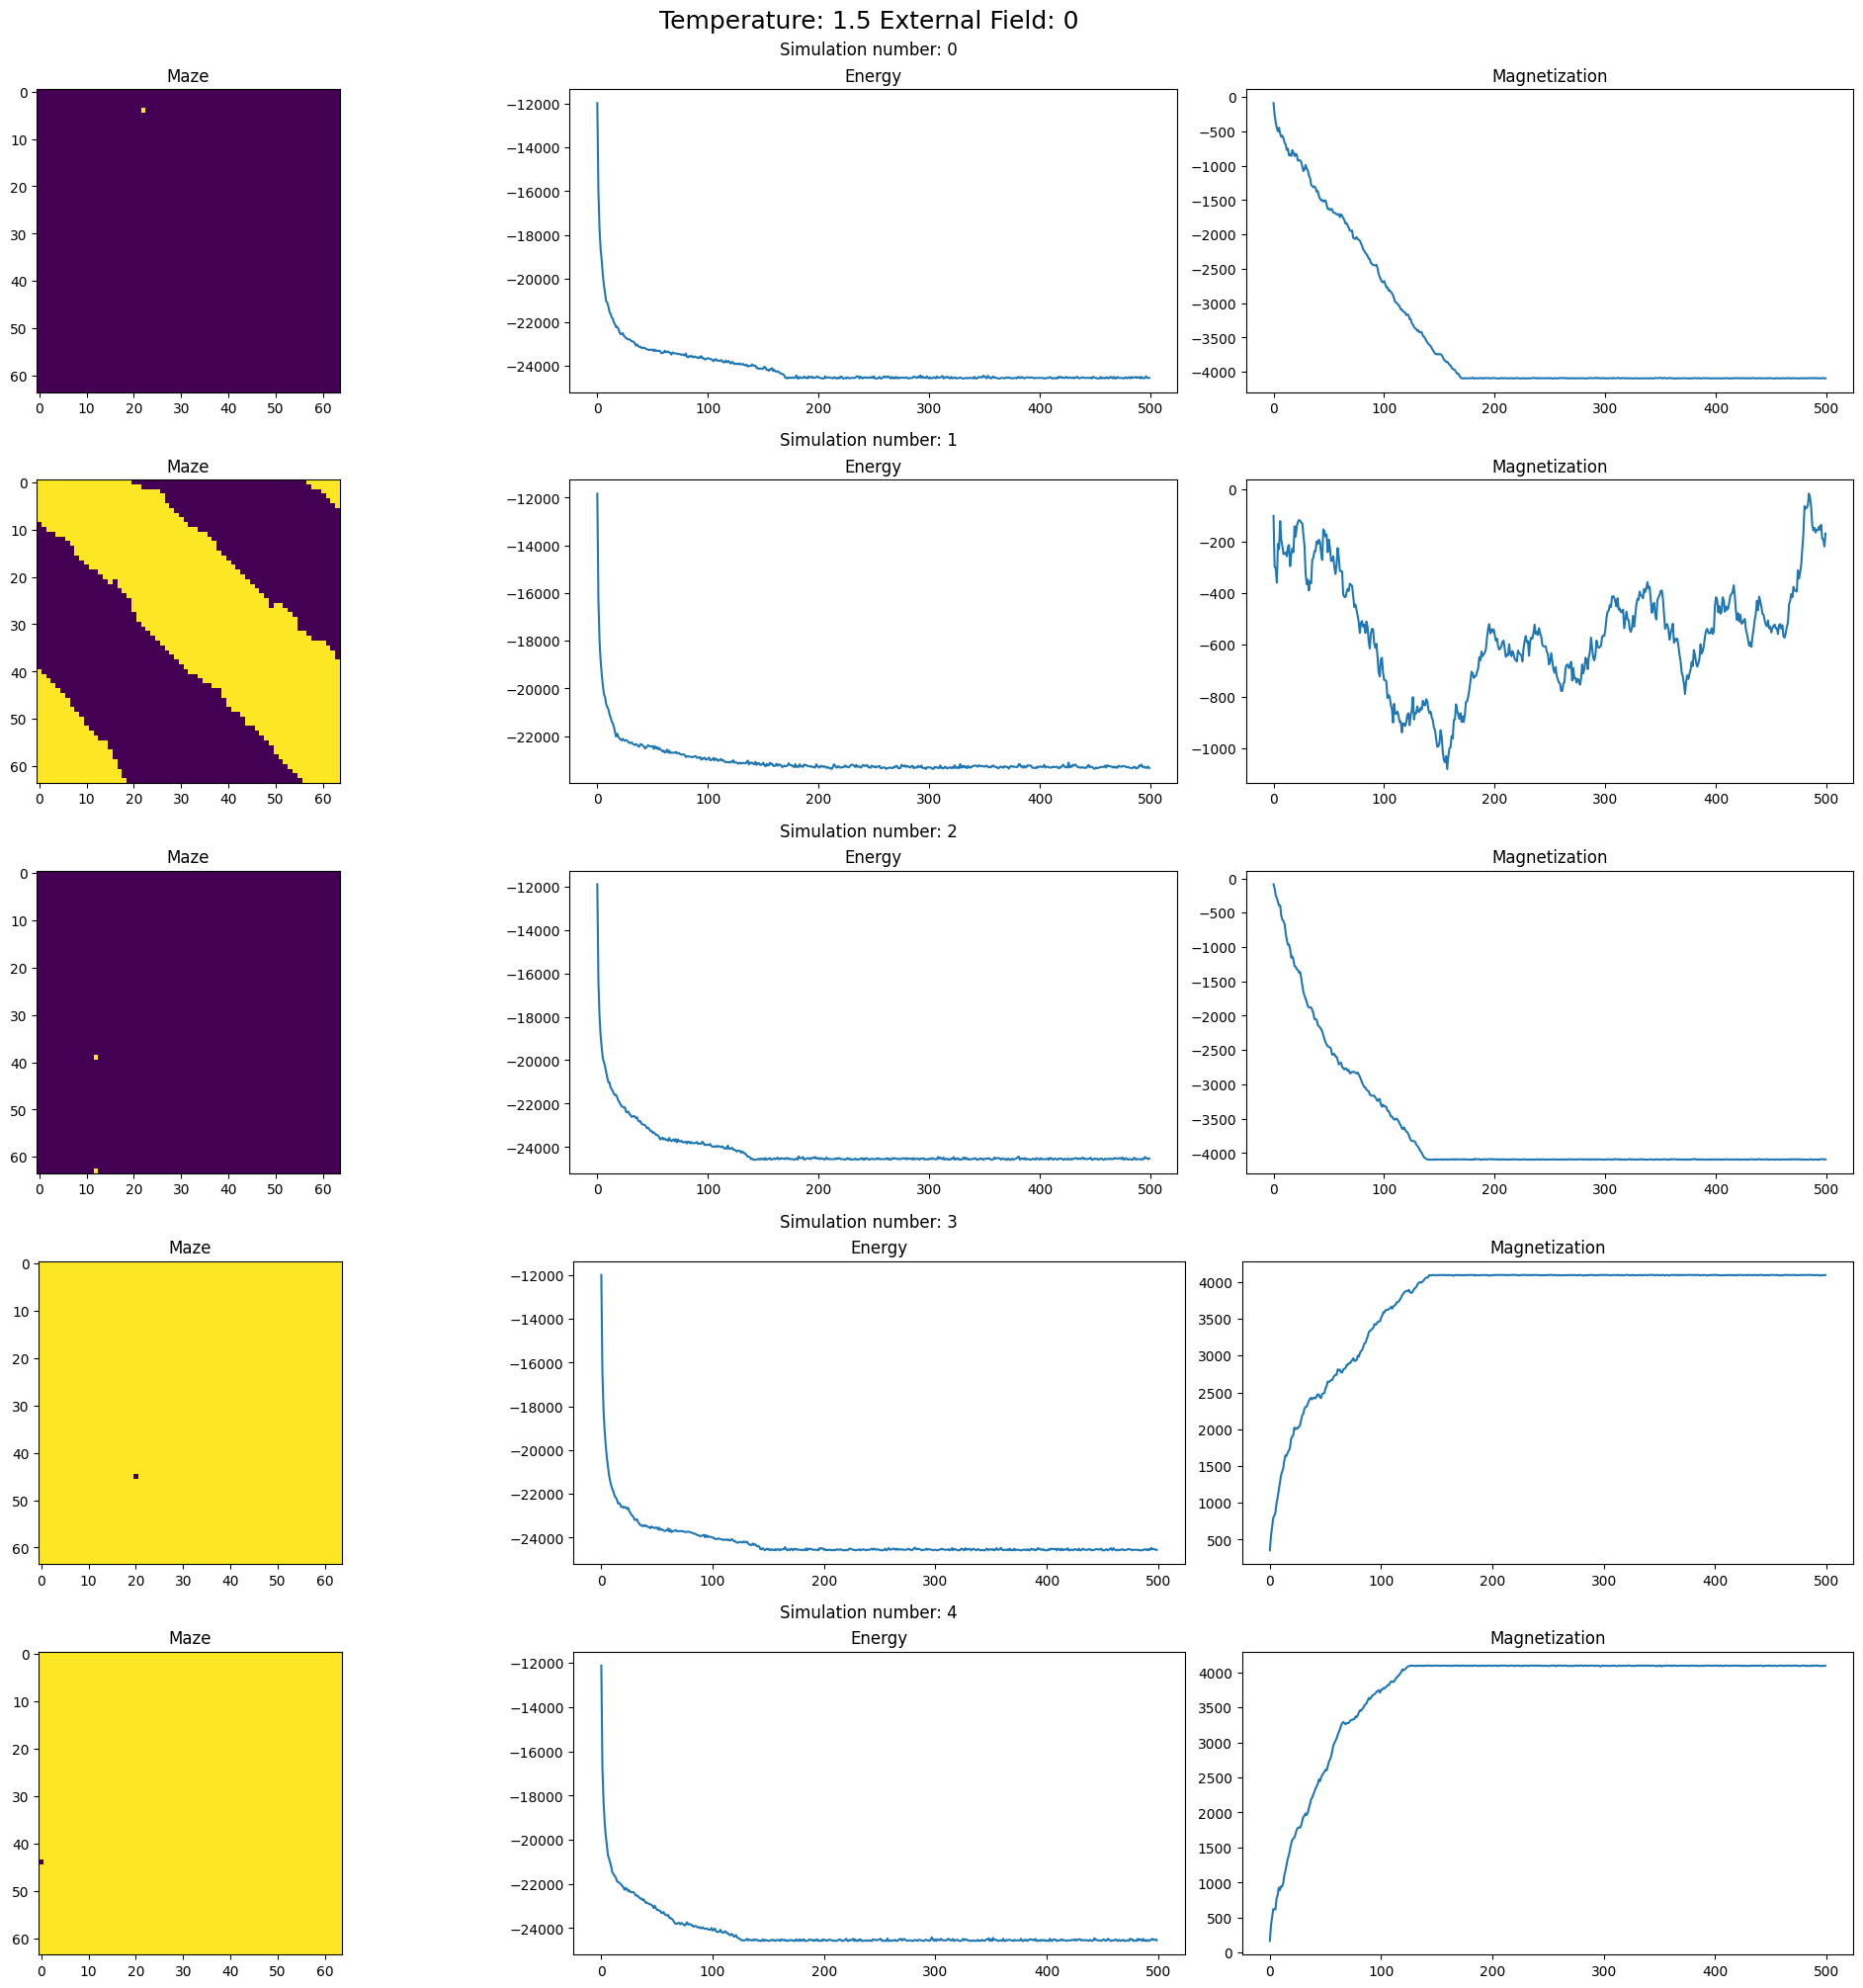

In [3]:
time_series("Rust/Demo/Low")

## High temperature
Simulation starts not too far from the equilibrium and oscilates vividly

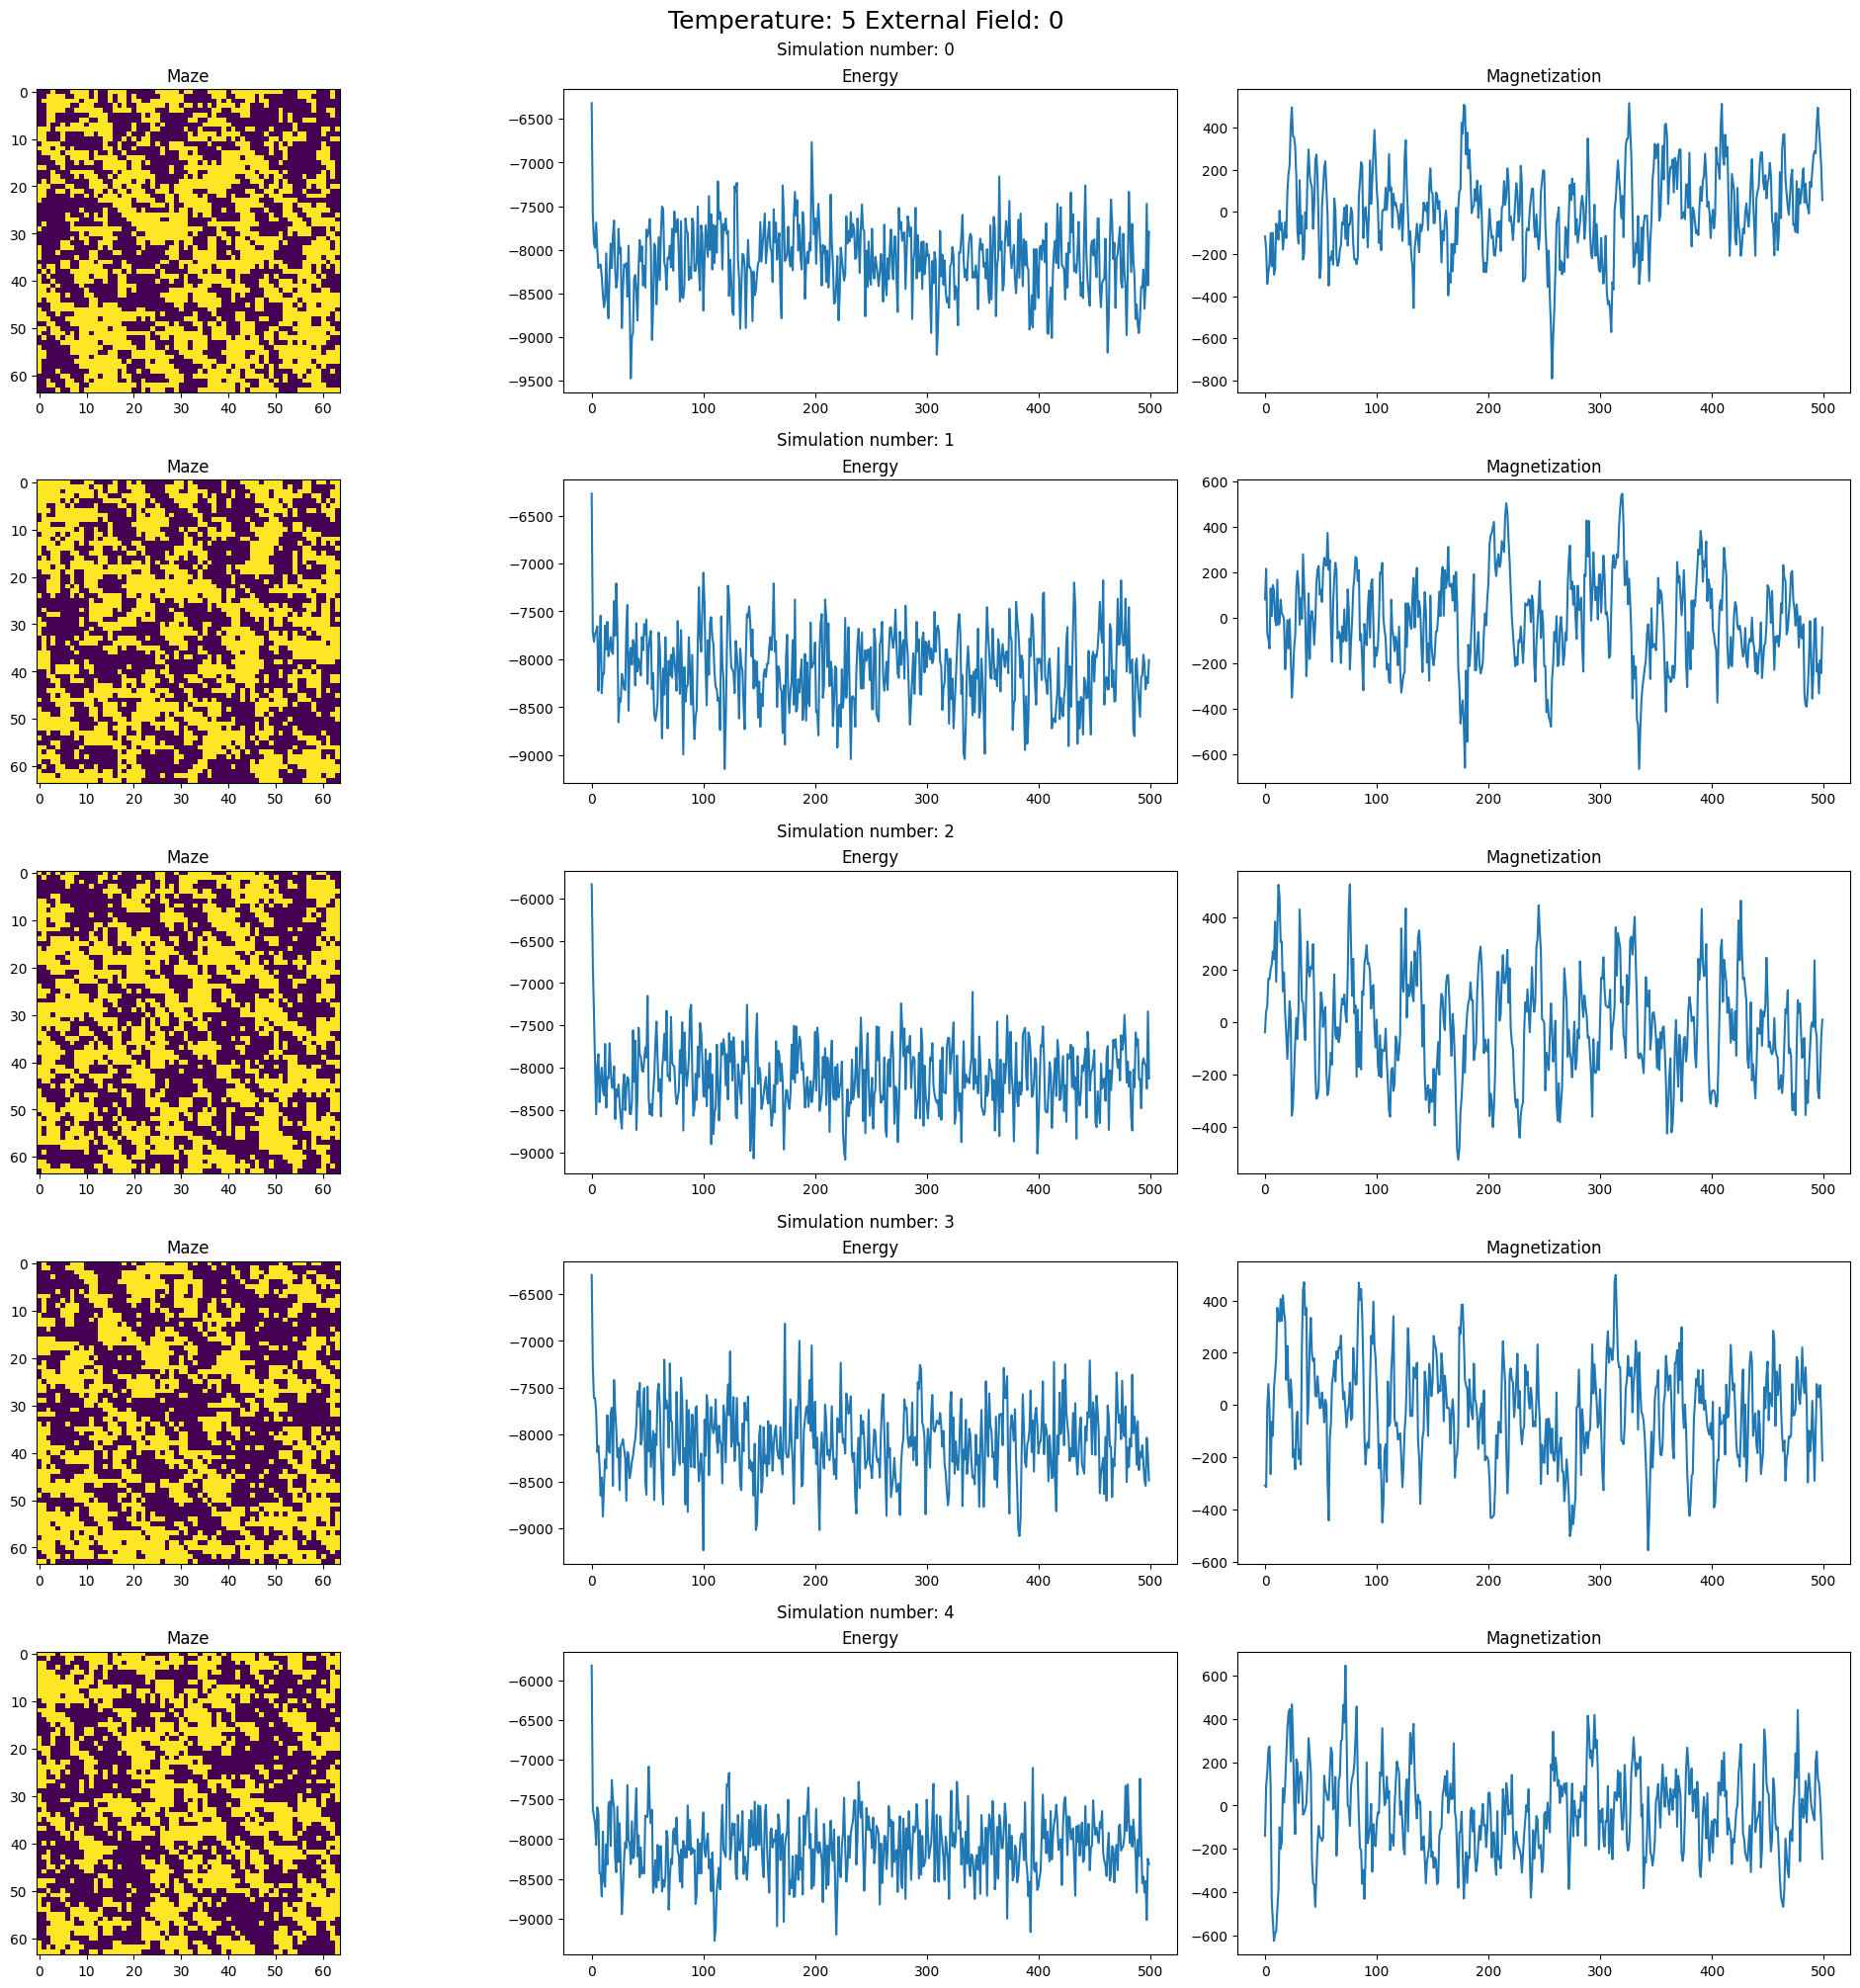

In [4]:
time_series("Rust/Demo/High")

## Around critical temperature
For 2d lattice with periodic boundary conditions $T_{crit} \approx 2.7$

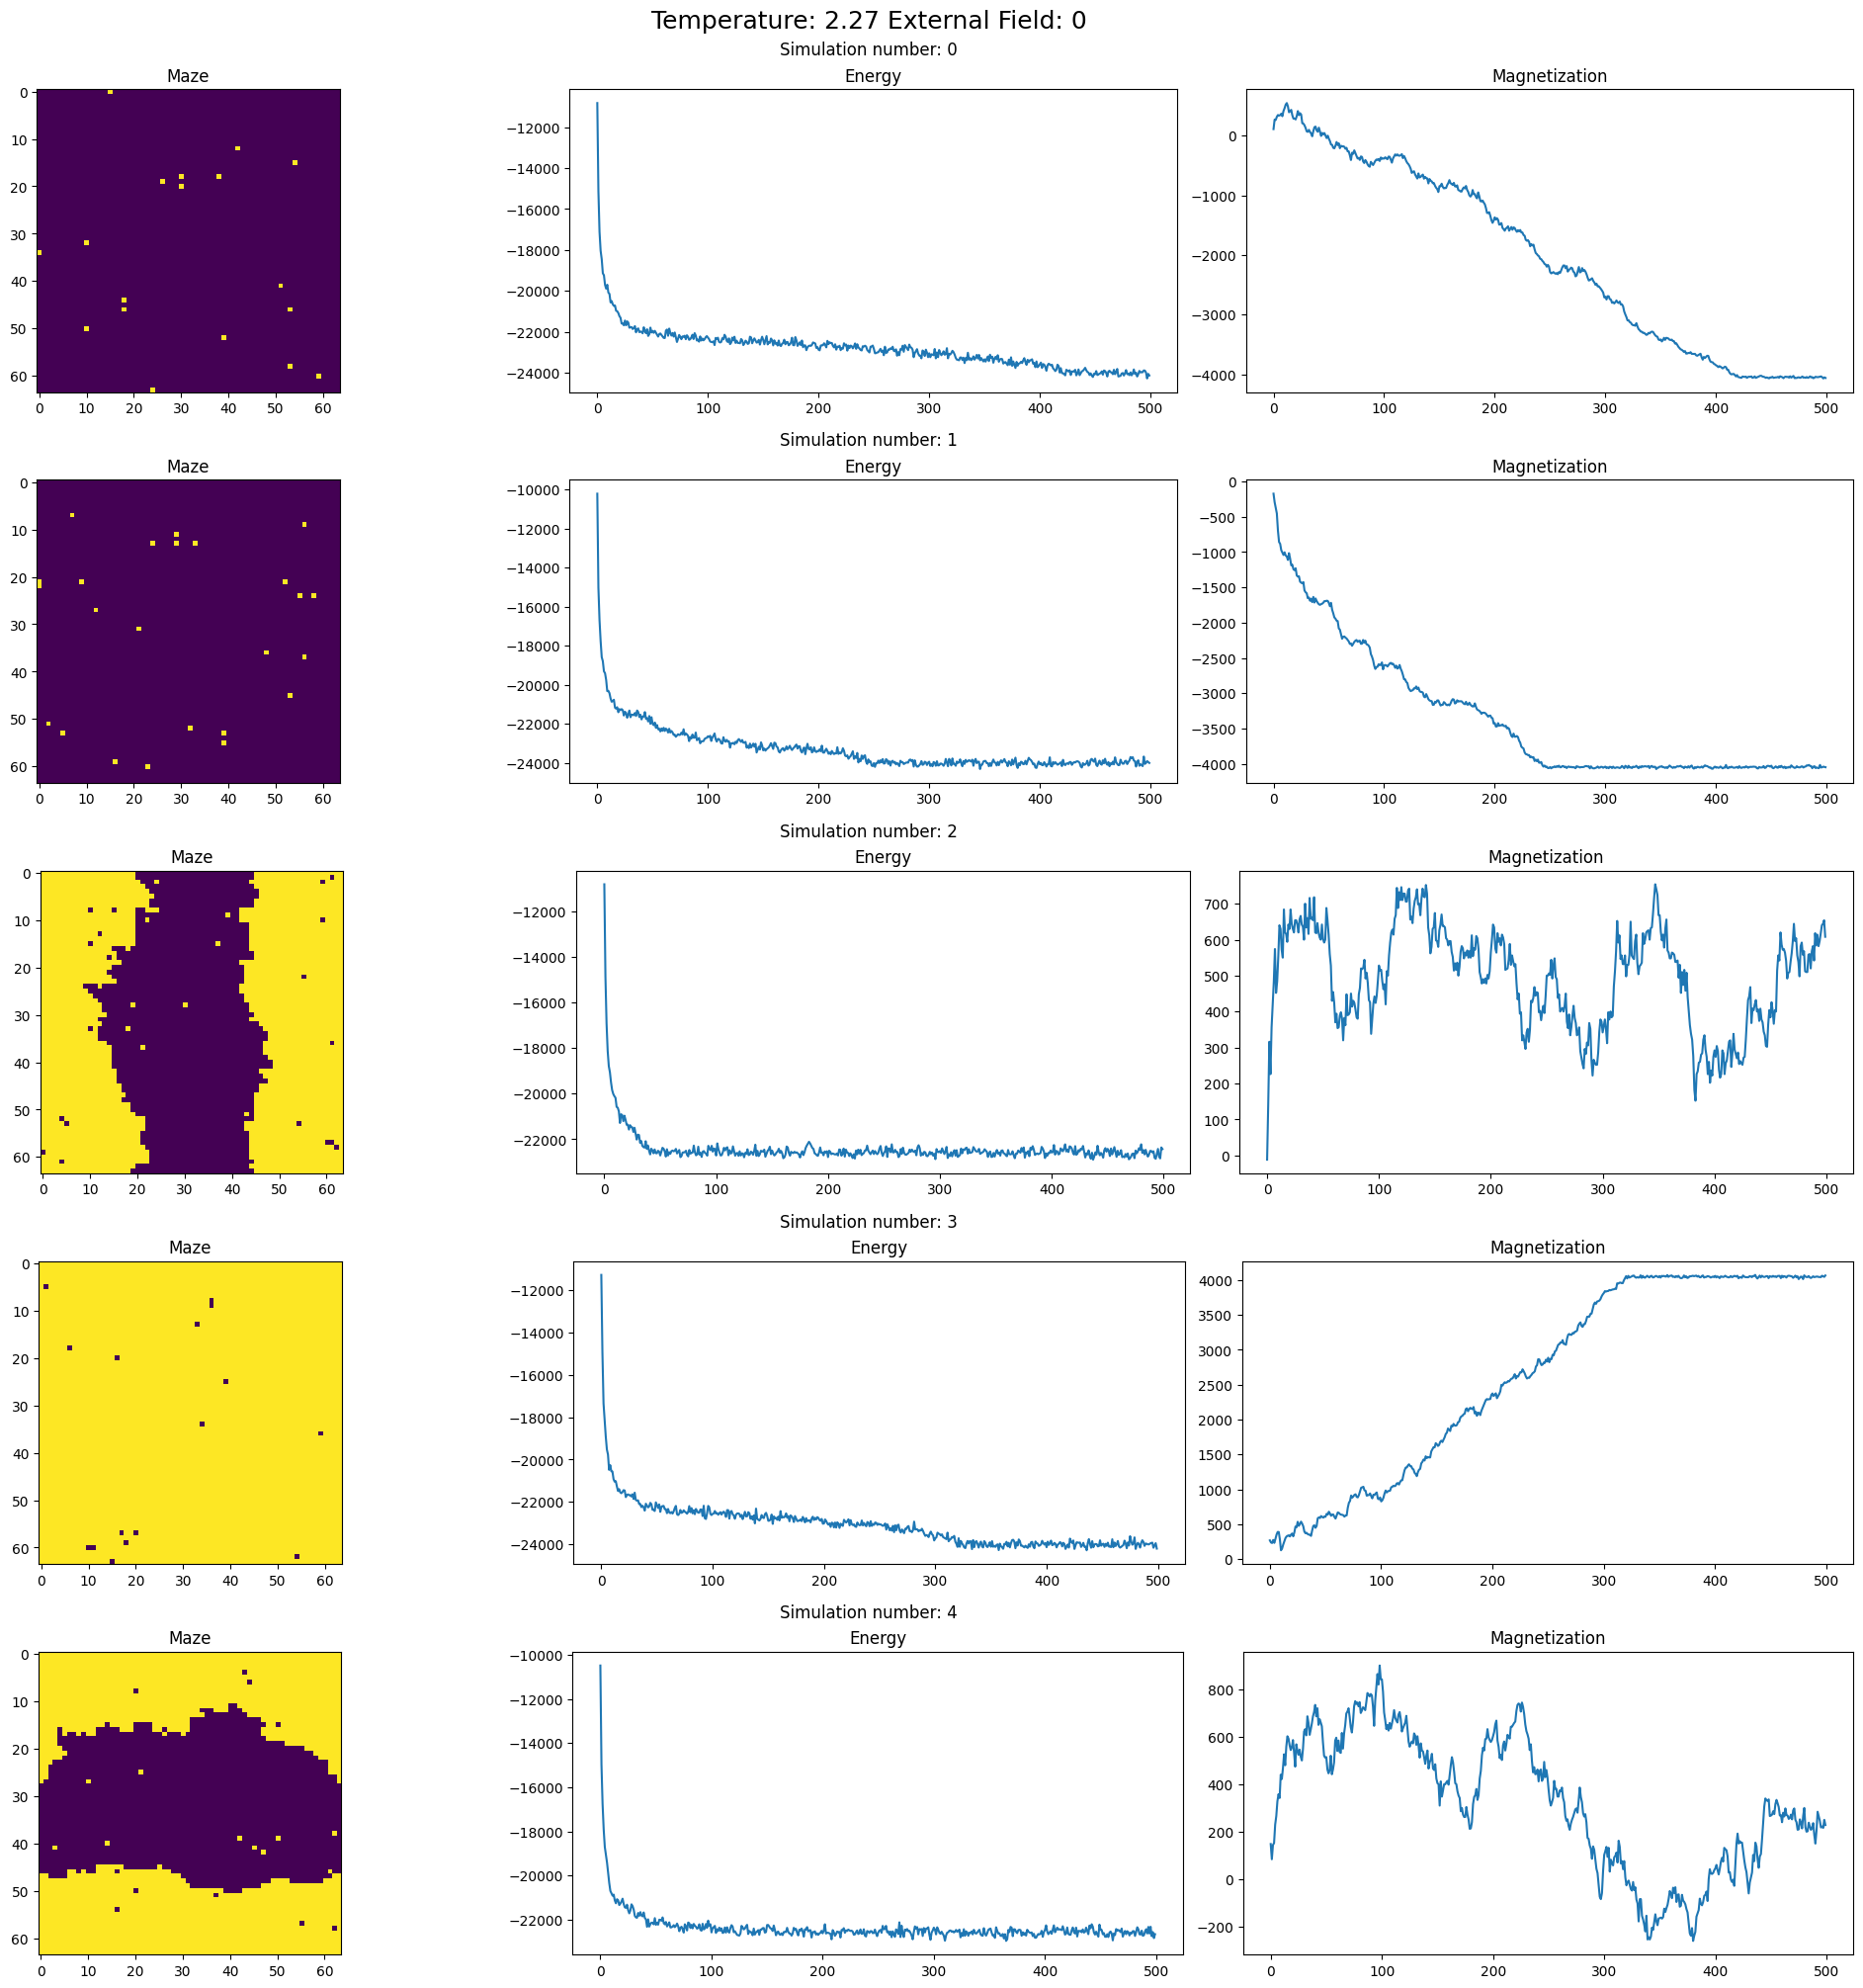

In [5]:
time_series("Rust/Demo/Crit")

## Positive Magnetic Field

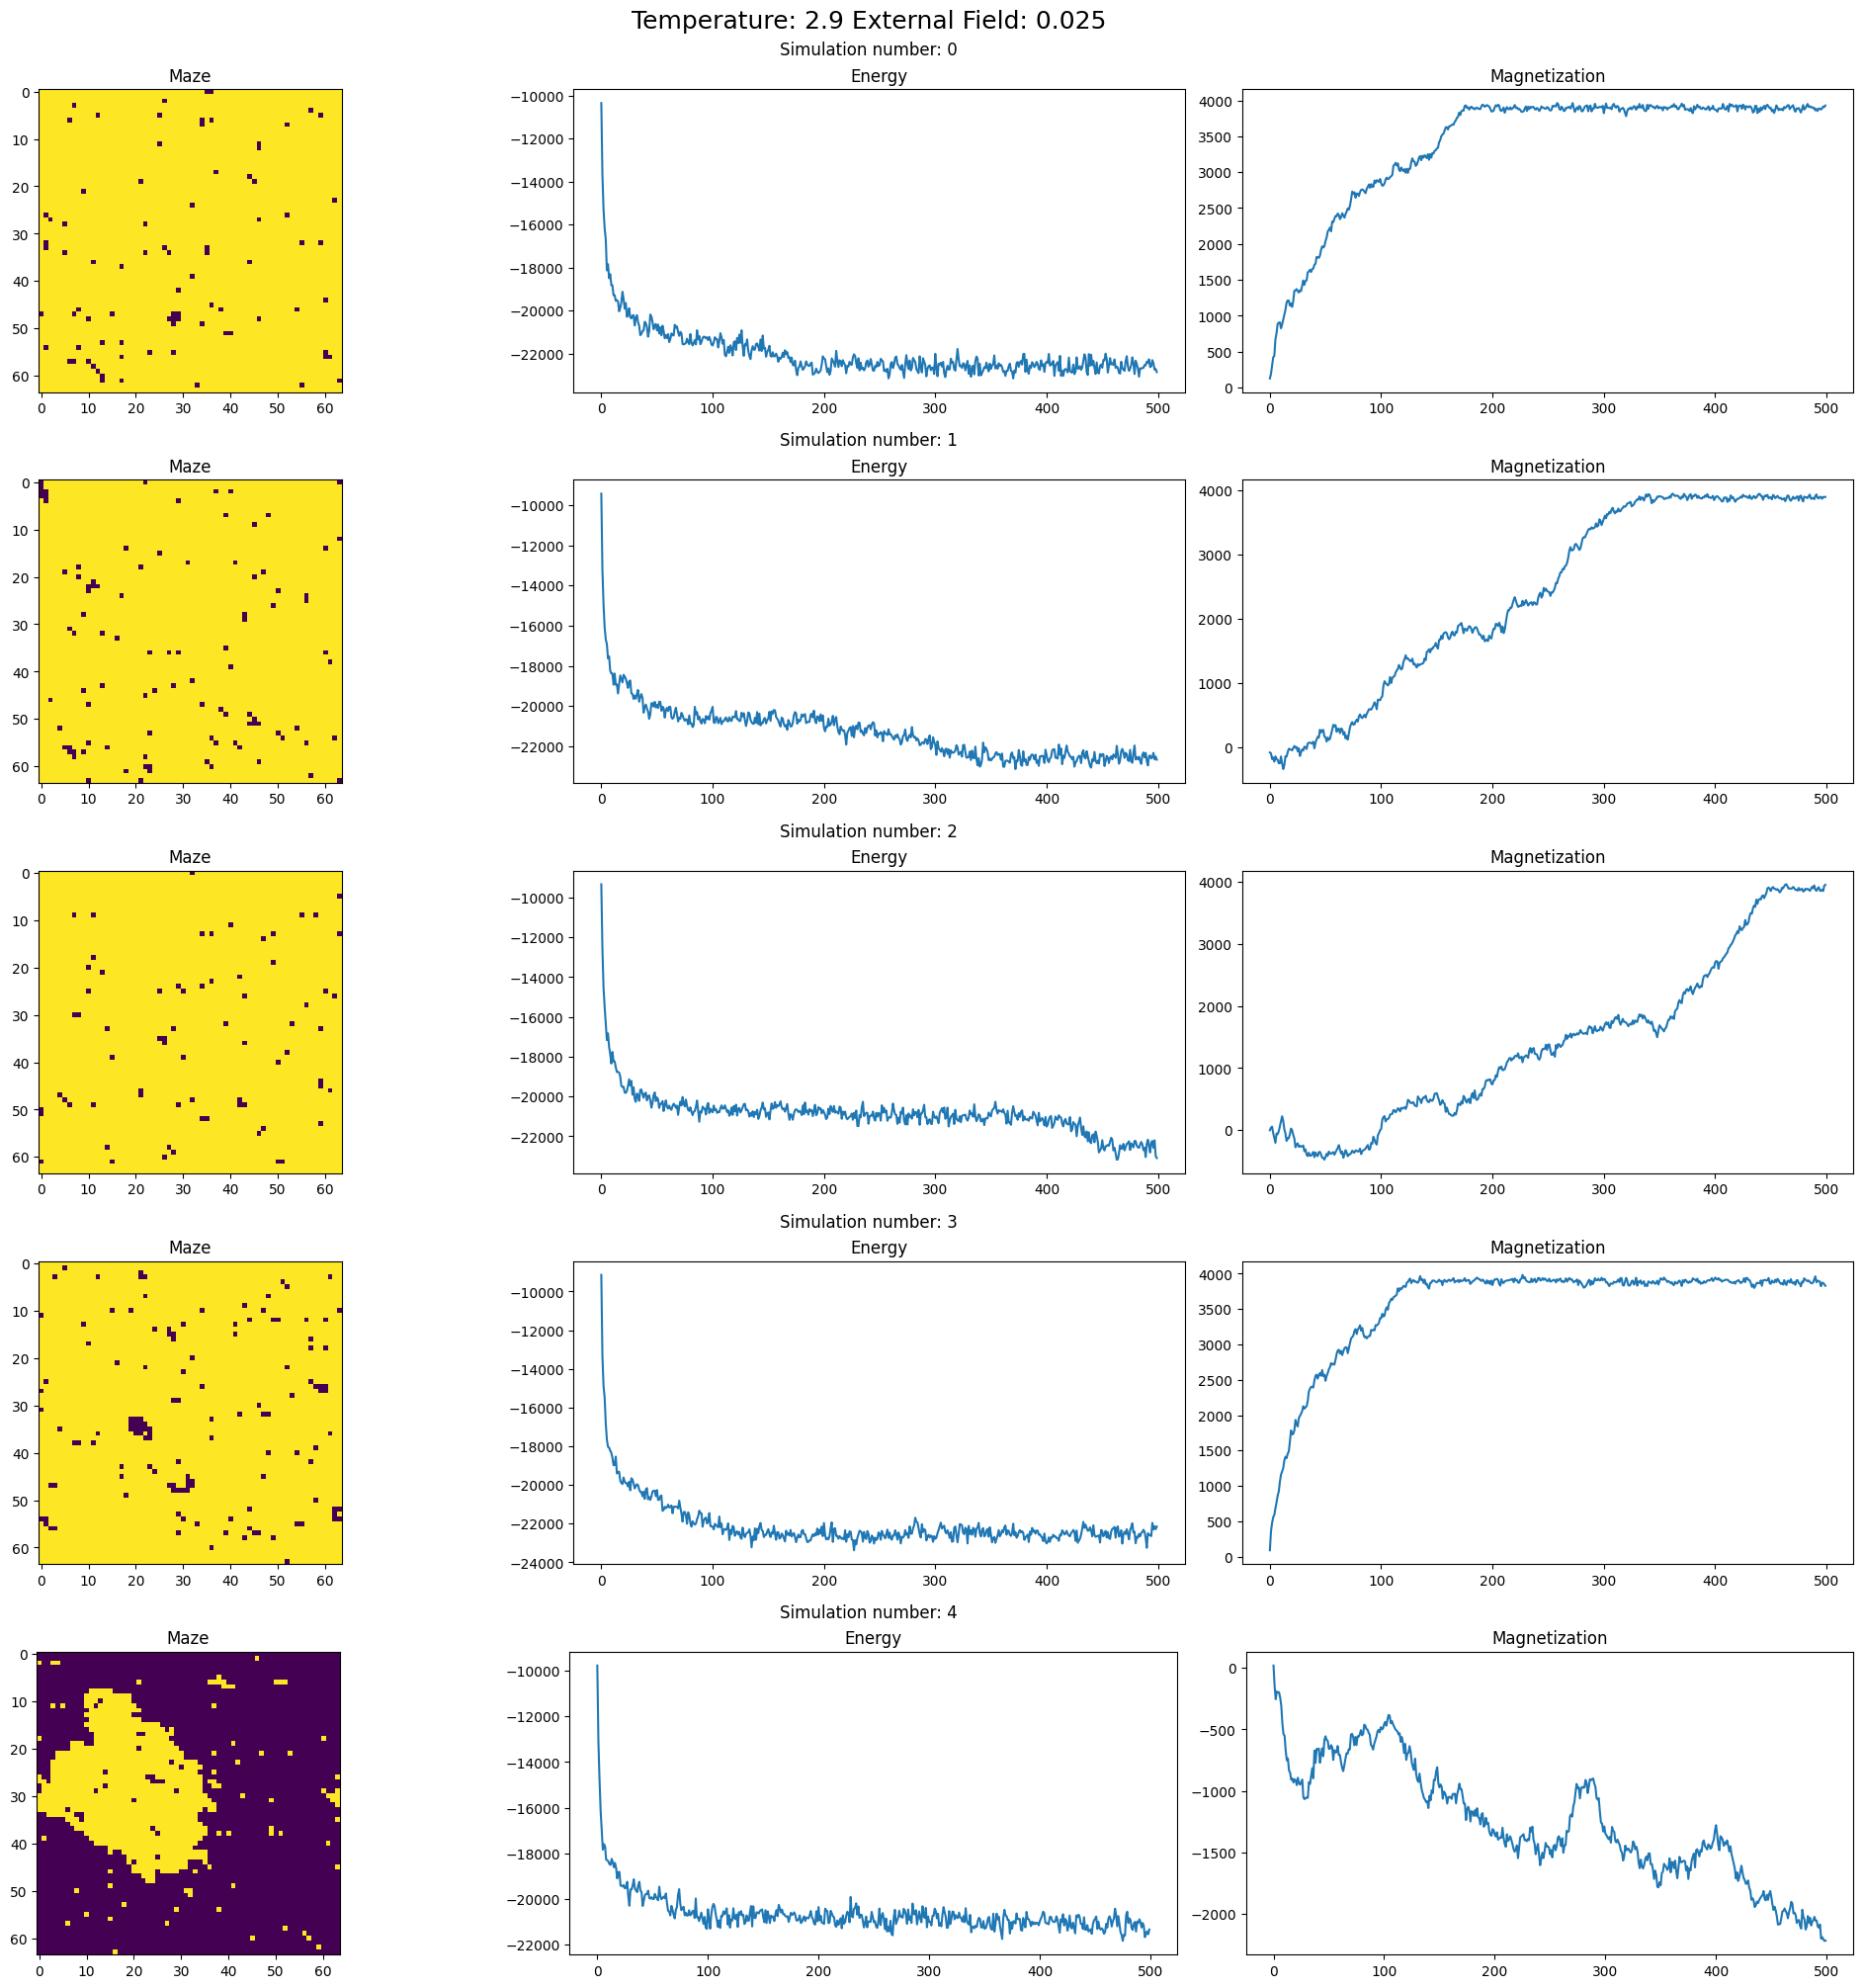

In [6]:
time_series("Rust/Demo/MagPositive/")

## Negative Magnetic Field

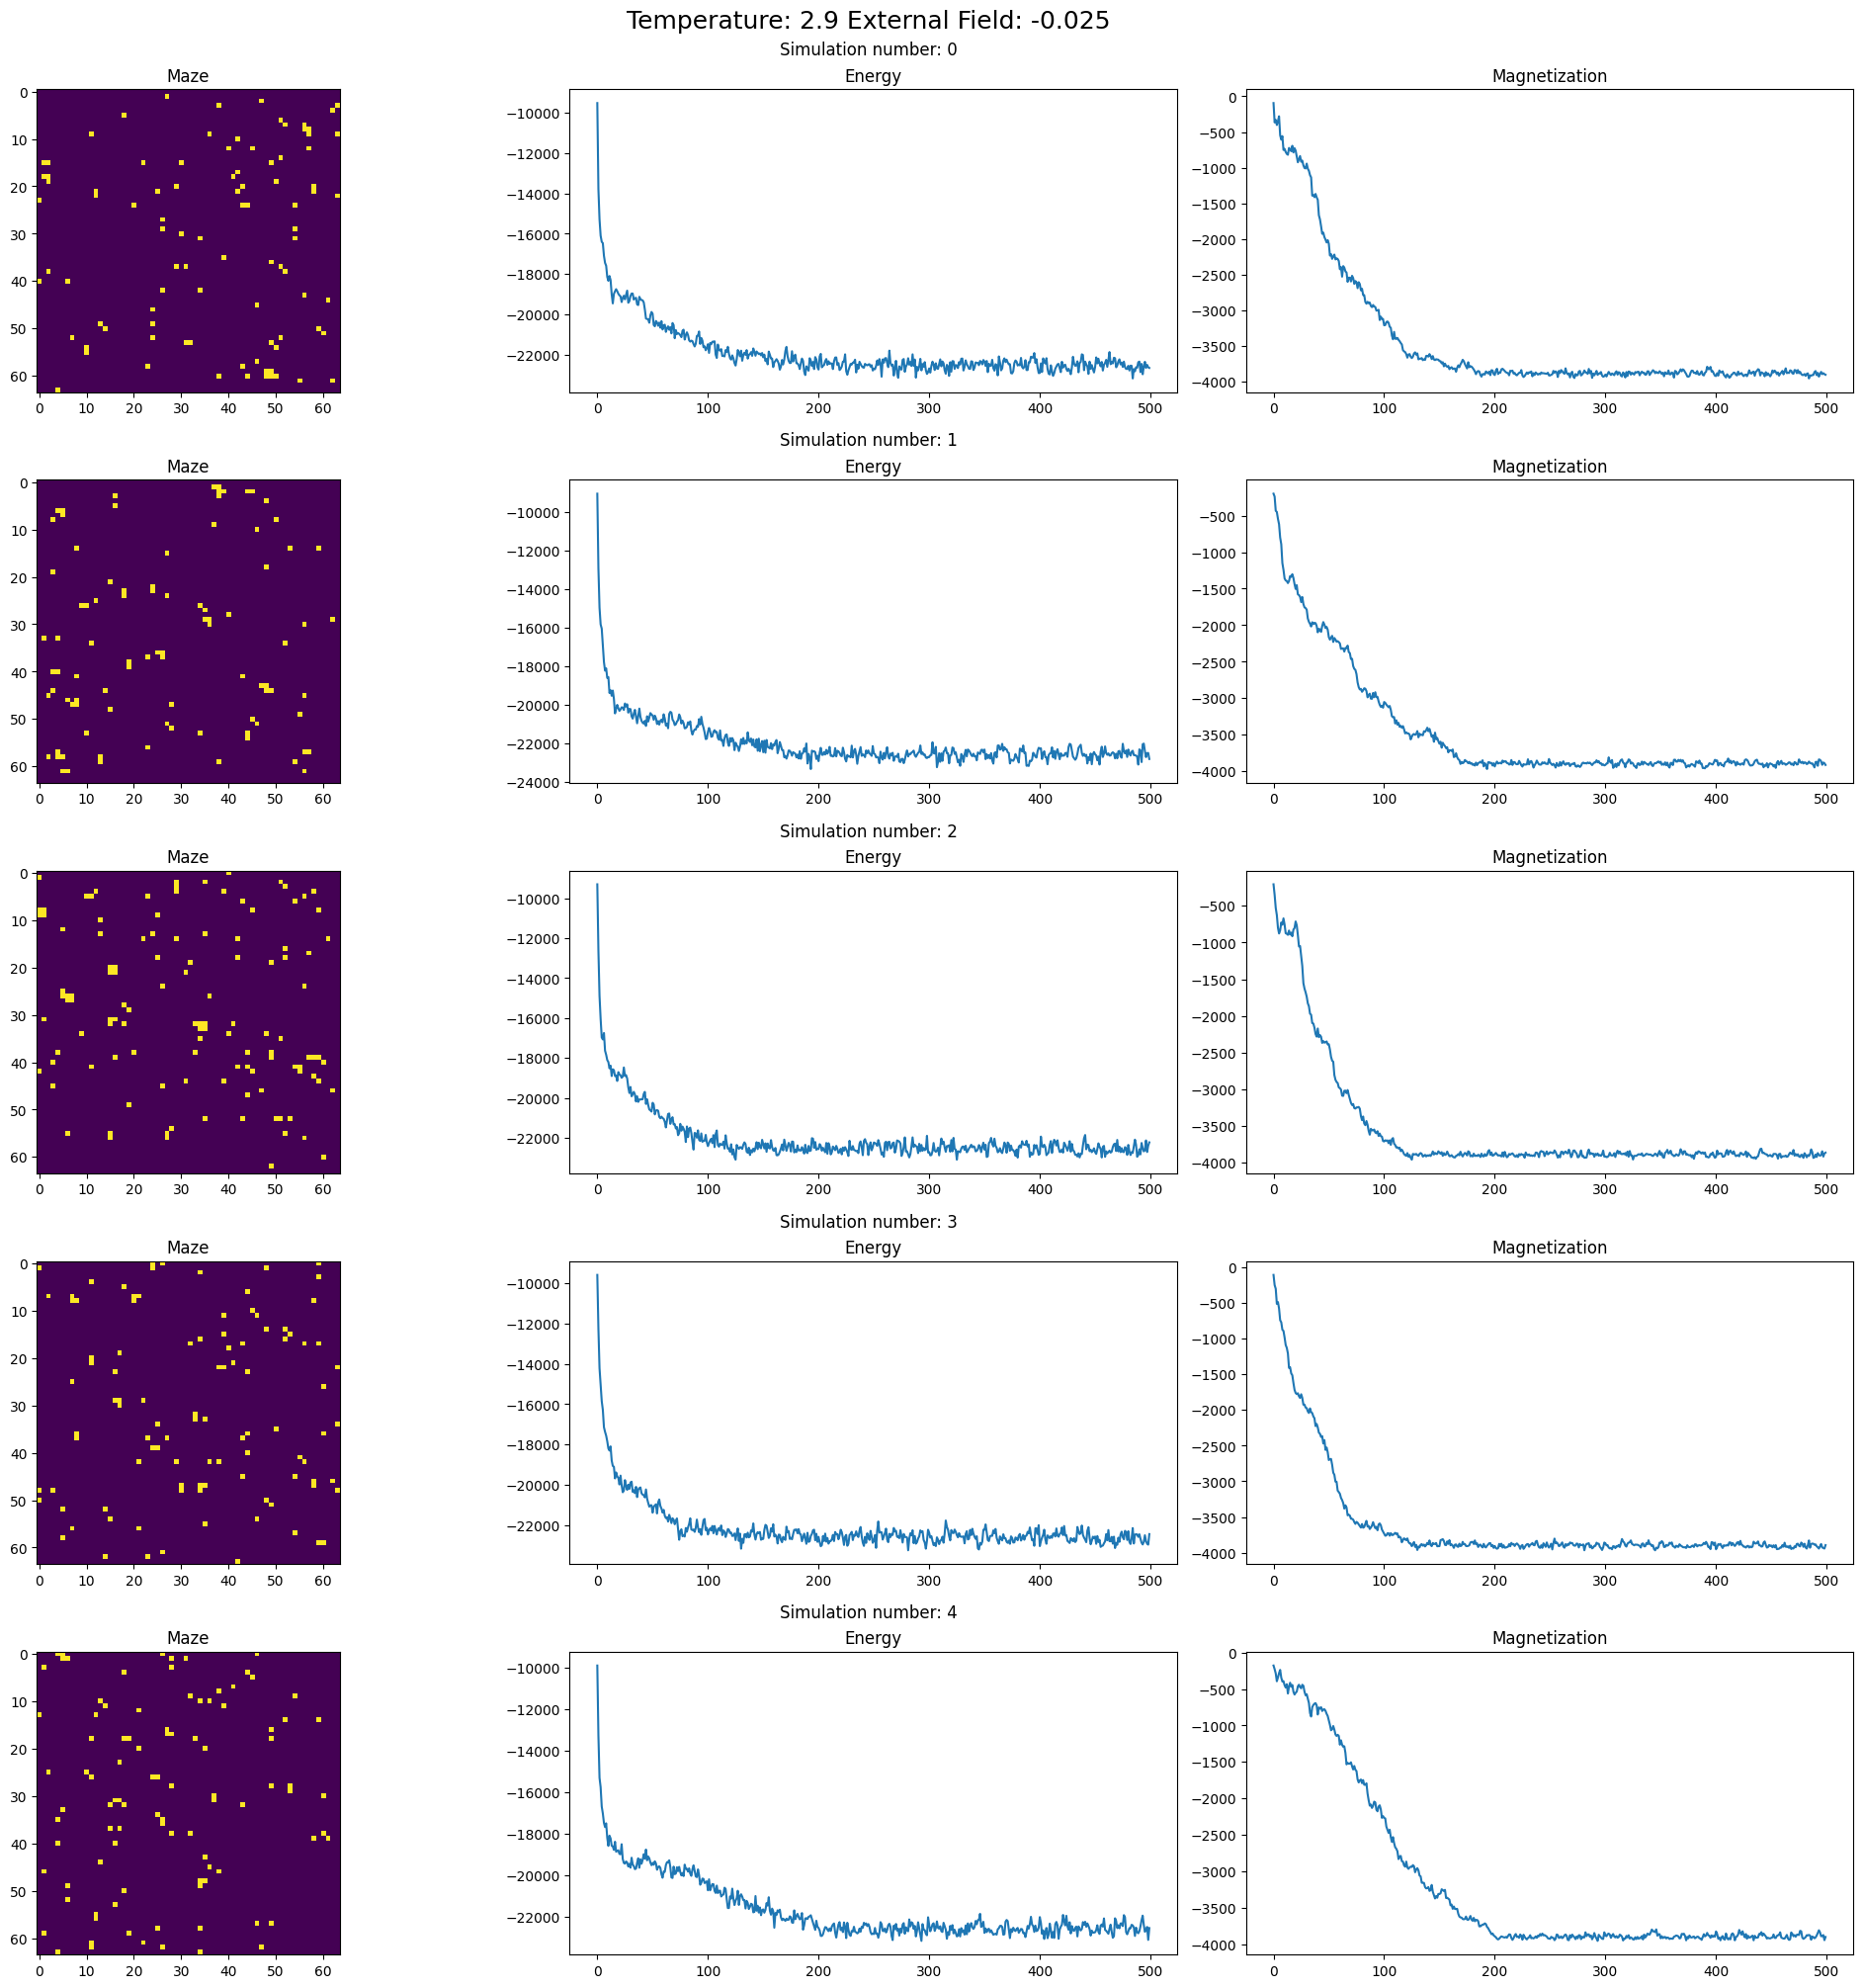

In [7]:
time_series("Rust/Demo/MagNegative/")

# New Simulate Function

Implementation based on numpy matrix operations

In [8]:
def iterate(m, T, H):
    m_sum = get_neighbour_sum_matrix_conv(m)
    e_diff = - (m_sum + H) * ( -2 * m)
    spin_flip_mask = np.random.rand(*m.shape)<np.where(e_diff>0,np.exp(-e_diff/T), 1.0) 
    m = m + m*(-2)*spin_flip_mask
    return m

def get_maze(N = 64):
    m = 2 * np.random.randint(0,2,(N,N)) -1
    return m

def simulate(n, T, H):
    m = get_maze()
    energies = []
    magnetizations = []
    for _ in range(n):
        m = iterate(m, T, H)
        energies.append(calcEnergy(m))
        magnetizations.append(calcMag(m))
    return energies, magnetizations, m


In [9]:
def simulate_with_plot(num, simulate, steps = 300, h = 0, ):
    n_rows = num

    fig = plt.figure(constrained_layout=True, figsize=(20, 20))
    subfigs = fig.subfigures(nrows=n_rows, ncols=1)

    for index, subfig in enumerate(subfigs):
        random_temperature = np.random.rand() * 4 + 1
        energies, magnetization, mat = simulate(steps, random_temperature, h)
        subfig.suptitle(f'Nr: {index} Temperature: {random_temperature:.2f}')

        axs = subfig.subplots(nrows=1, ncols=3)

        axs[0].imshow(mat)
        axs[0].set_title(f'Maze')

        axs[1].plot(energies)
        axs[1].set_title(f'Energy')

        axs[2].plot(magnetization)
        axs[2].set_title(f'Magnetization')

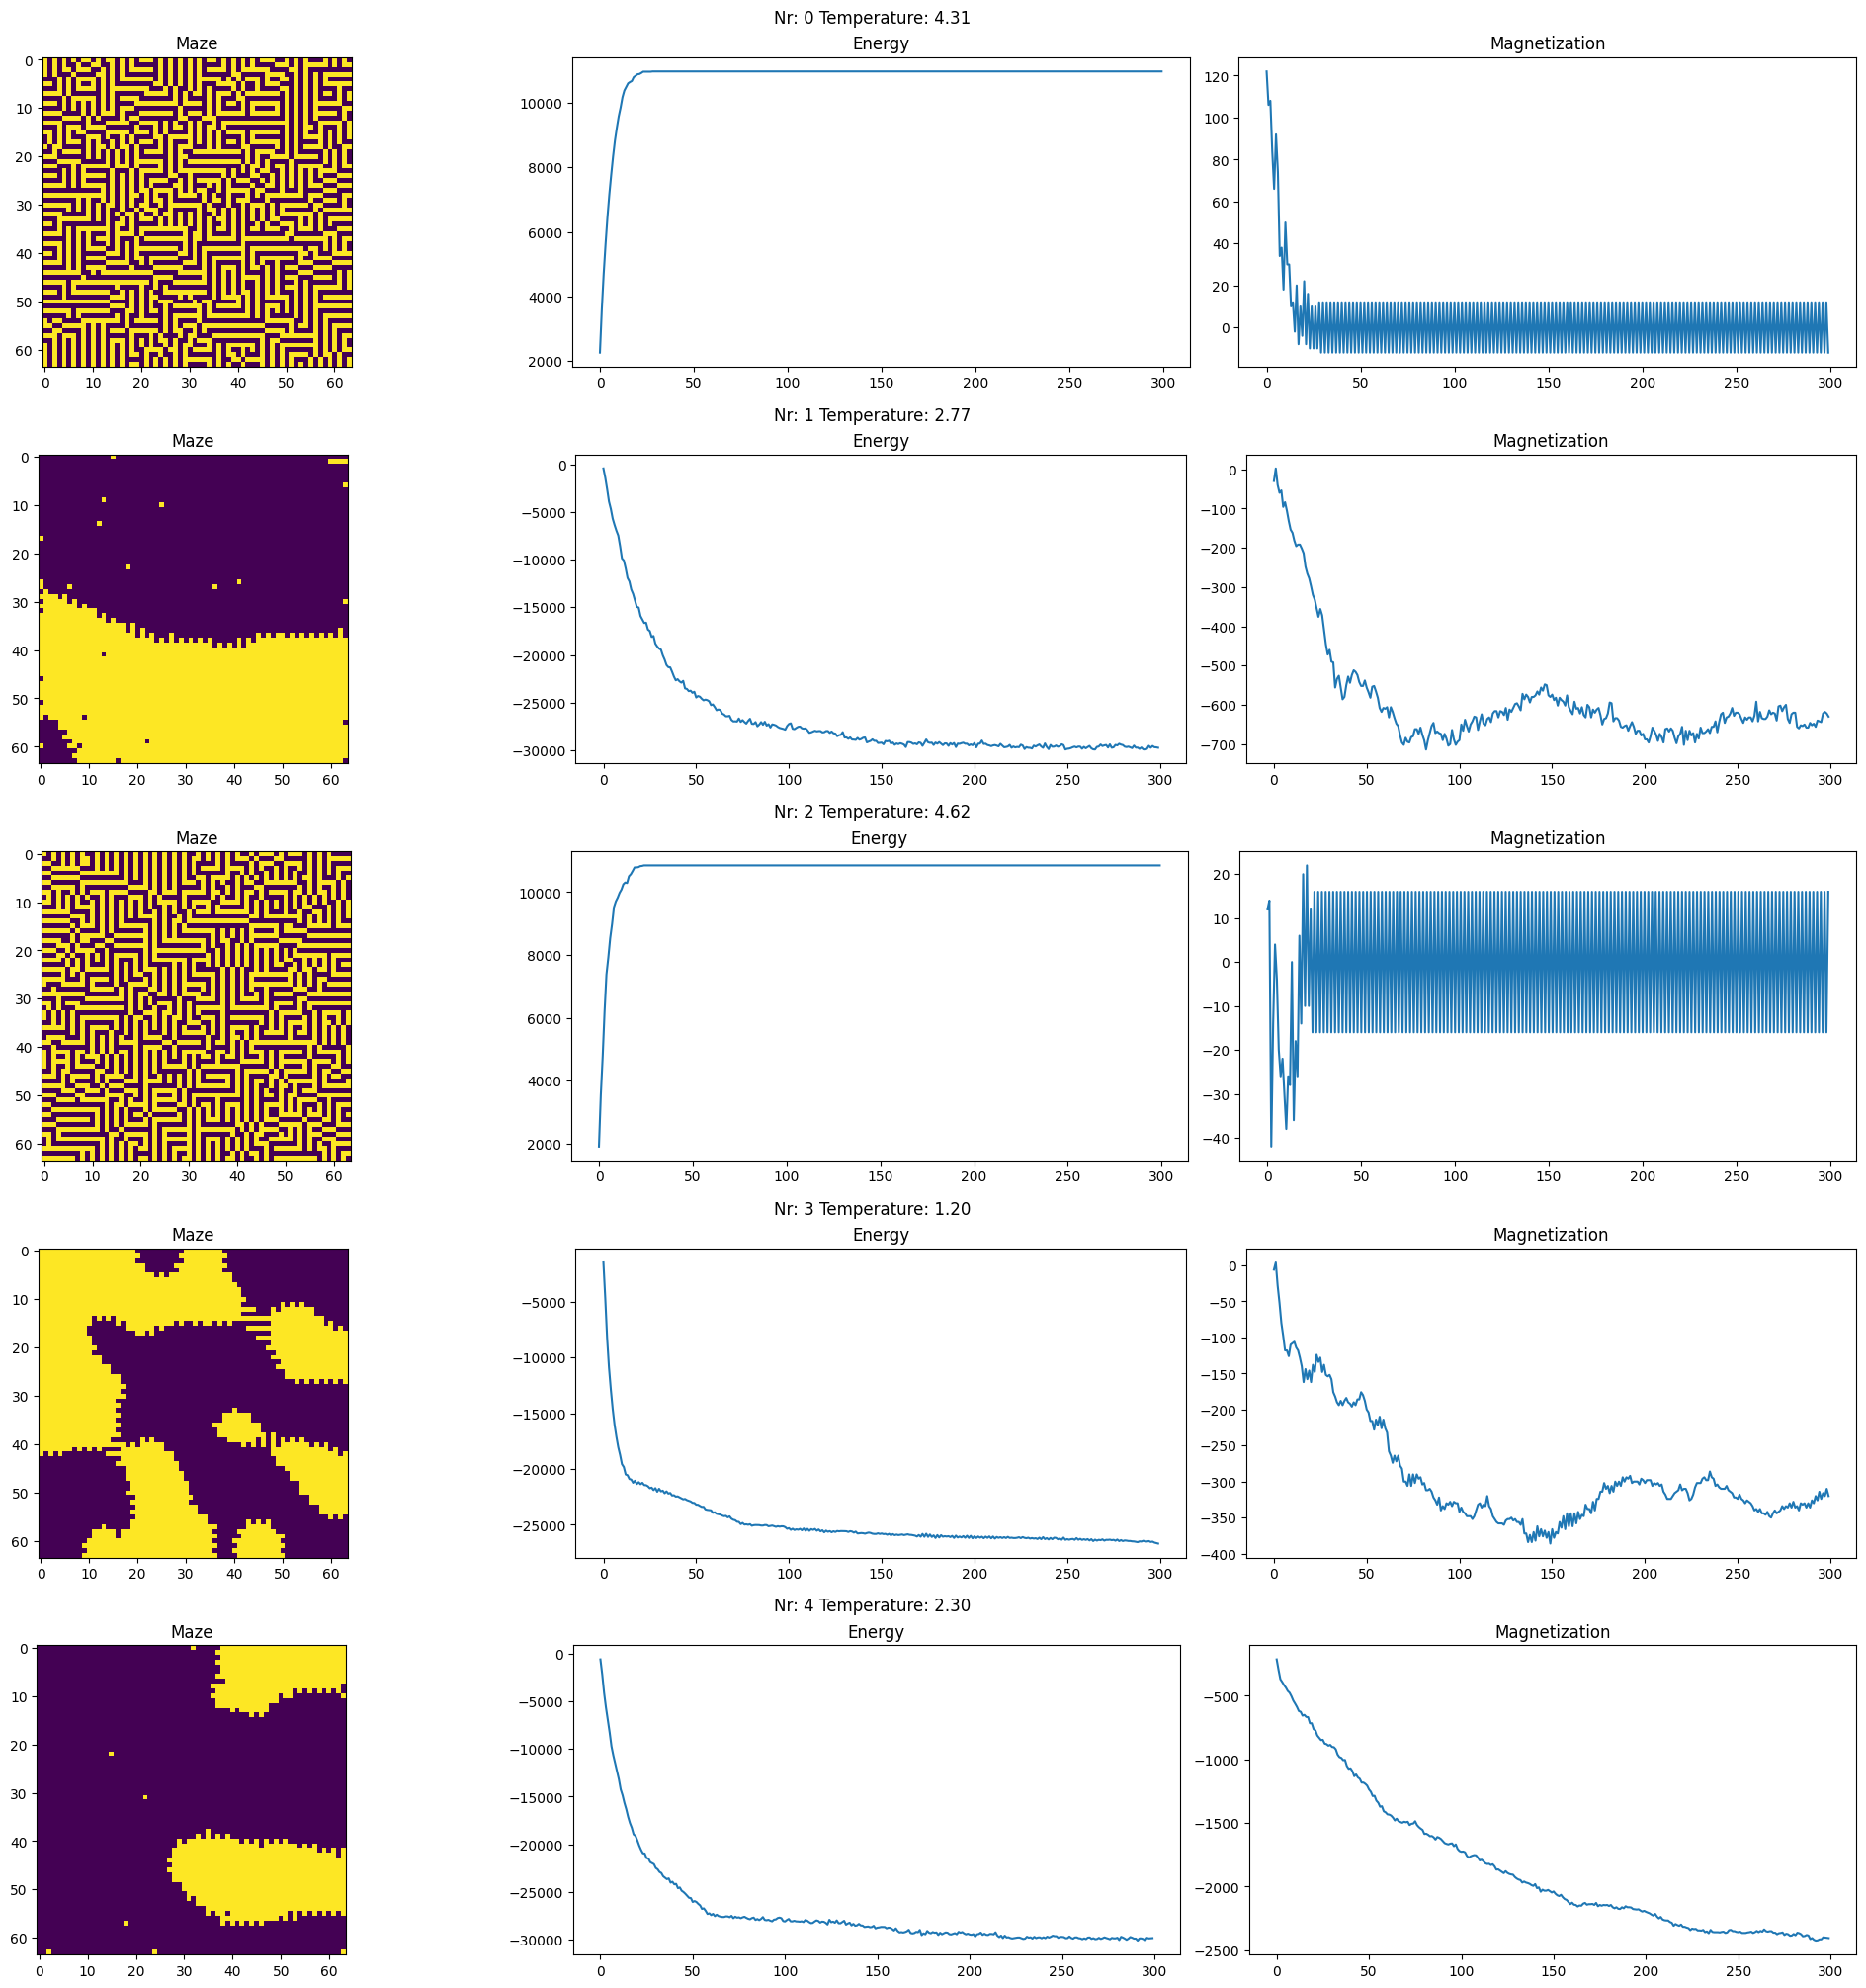

In [10]:
simulate_with_plot(5, simulate)

# Wolff

Flipping clusters of spins

In [11]:
def flipCluster(mat,cluster):
    # Flip all spins in a cluster. Used for the Wolff algorithm.
    """
    Parameters:
        mat: numpy array containing the current spin configuration
        cluster: List of spins to be flipped 
    """
    for pair in cluster:
        i,j=pair
        mat[i,j]*=-1
        
def iterateWolff(mat,T):
    # Wolff algorithm
    """
    Parameters:
        mat: numpy array containing the current spin configuration
        T: Temperature for the simulation
    """
    L,_ = mat.shape
    tracker = np.zeros((L,L))
    
    i,j = np.random.randint(0,L,size=2)
    spin = mat[i,j]
    stack = [(i,j)]
    tracker[i,j]=1
    
    cluster = [(i,j)]
    while len(stack)>0:
        i,j = stack.pop()
        neighbors = [(i,(j+1)%L),(i,(j-1)%L),((i+1)%L,j),((i-1)%L,j),((i+1)%L,(j+1)%L),((i-1)%L,(j-1)%L)]
        for pair in neighbors:
            l,m = pair
            if (mat[l,m]==spin and tracker[l,m]==0 and np.random.random()< (1.0-np.exp(-2.0/T))):
                cluster.append((l,m))
                stack.append((l,m))
                tracker[l,m]=1
            
    flipCluster(mat,cluster)

def simulateWolff(n, T, H):
    mat = get_maze()
    energies = []
    magnetizations = []
    for step in range(n):
        iterateWolff(mat, T)
        energies.append(calcEnergy(mat))
        magnetizations.append(calcMag(mat))
    return  energies, magnetizations, mat

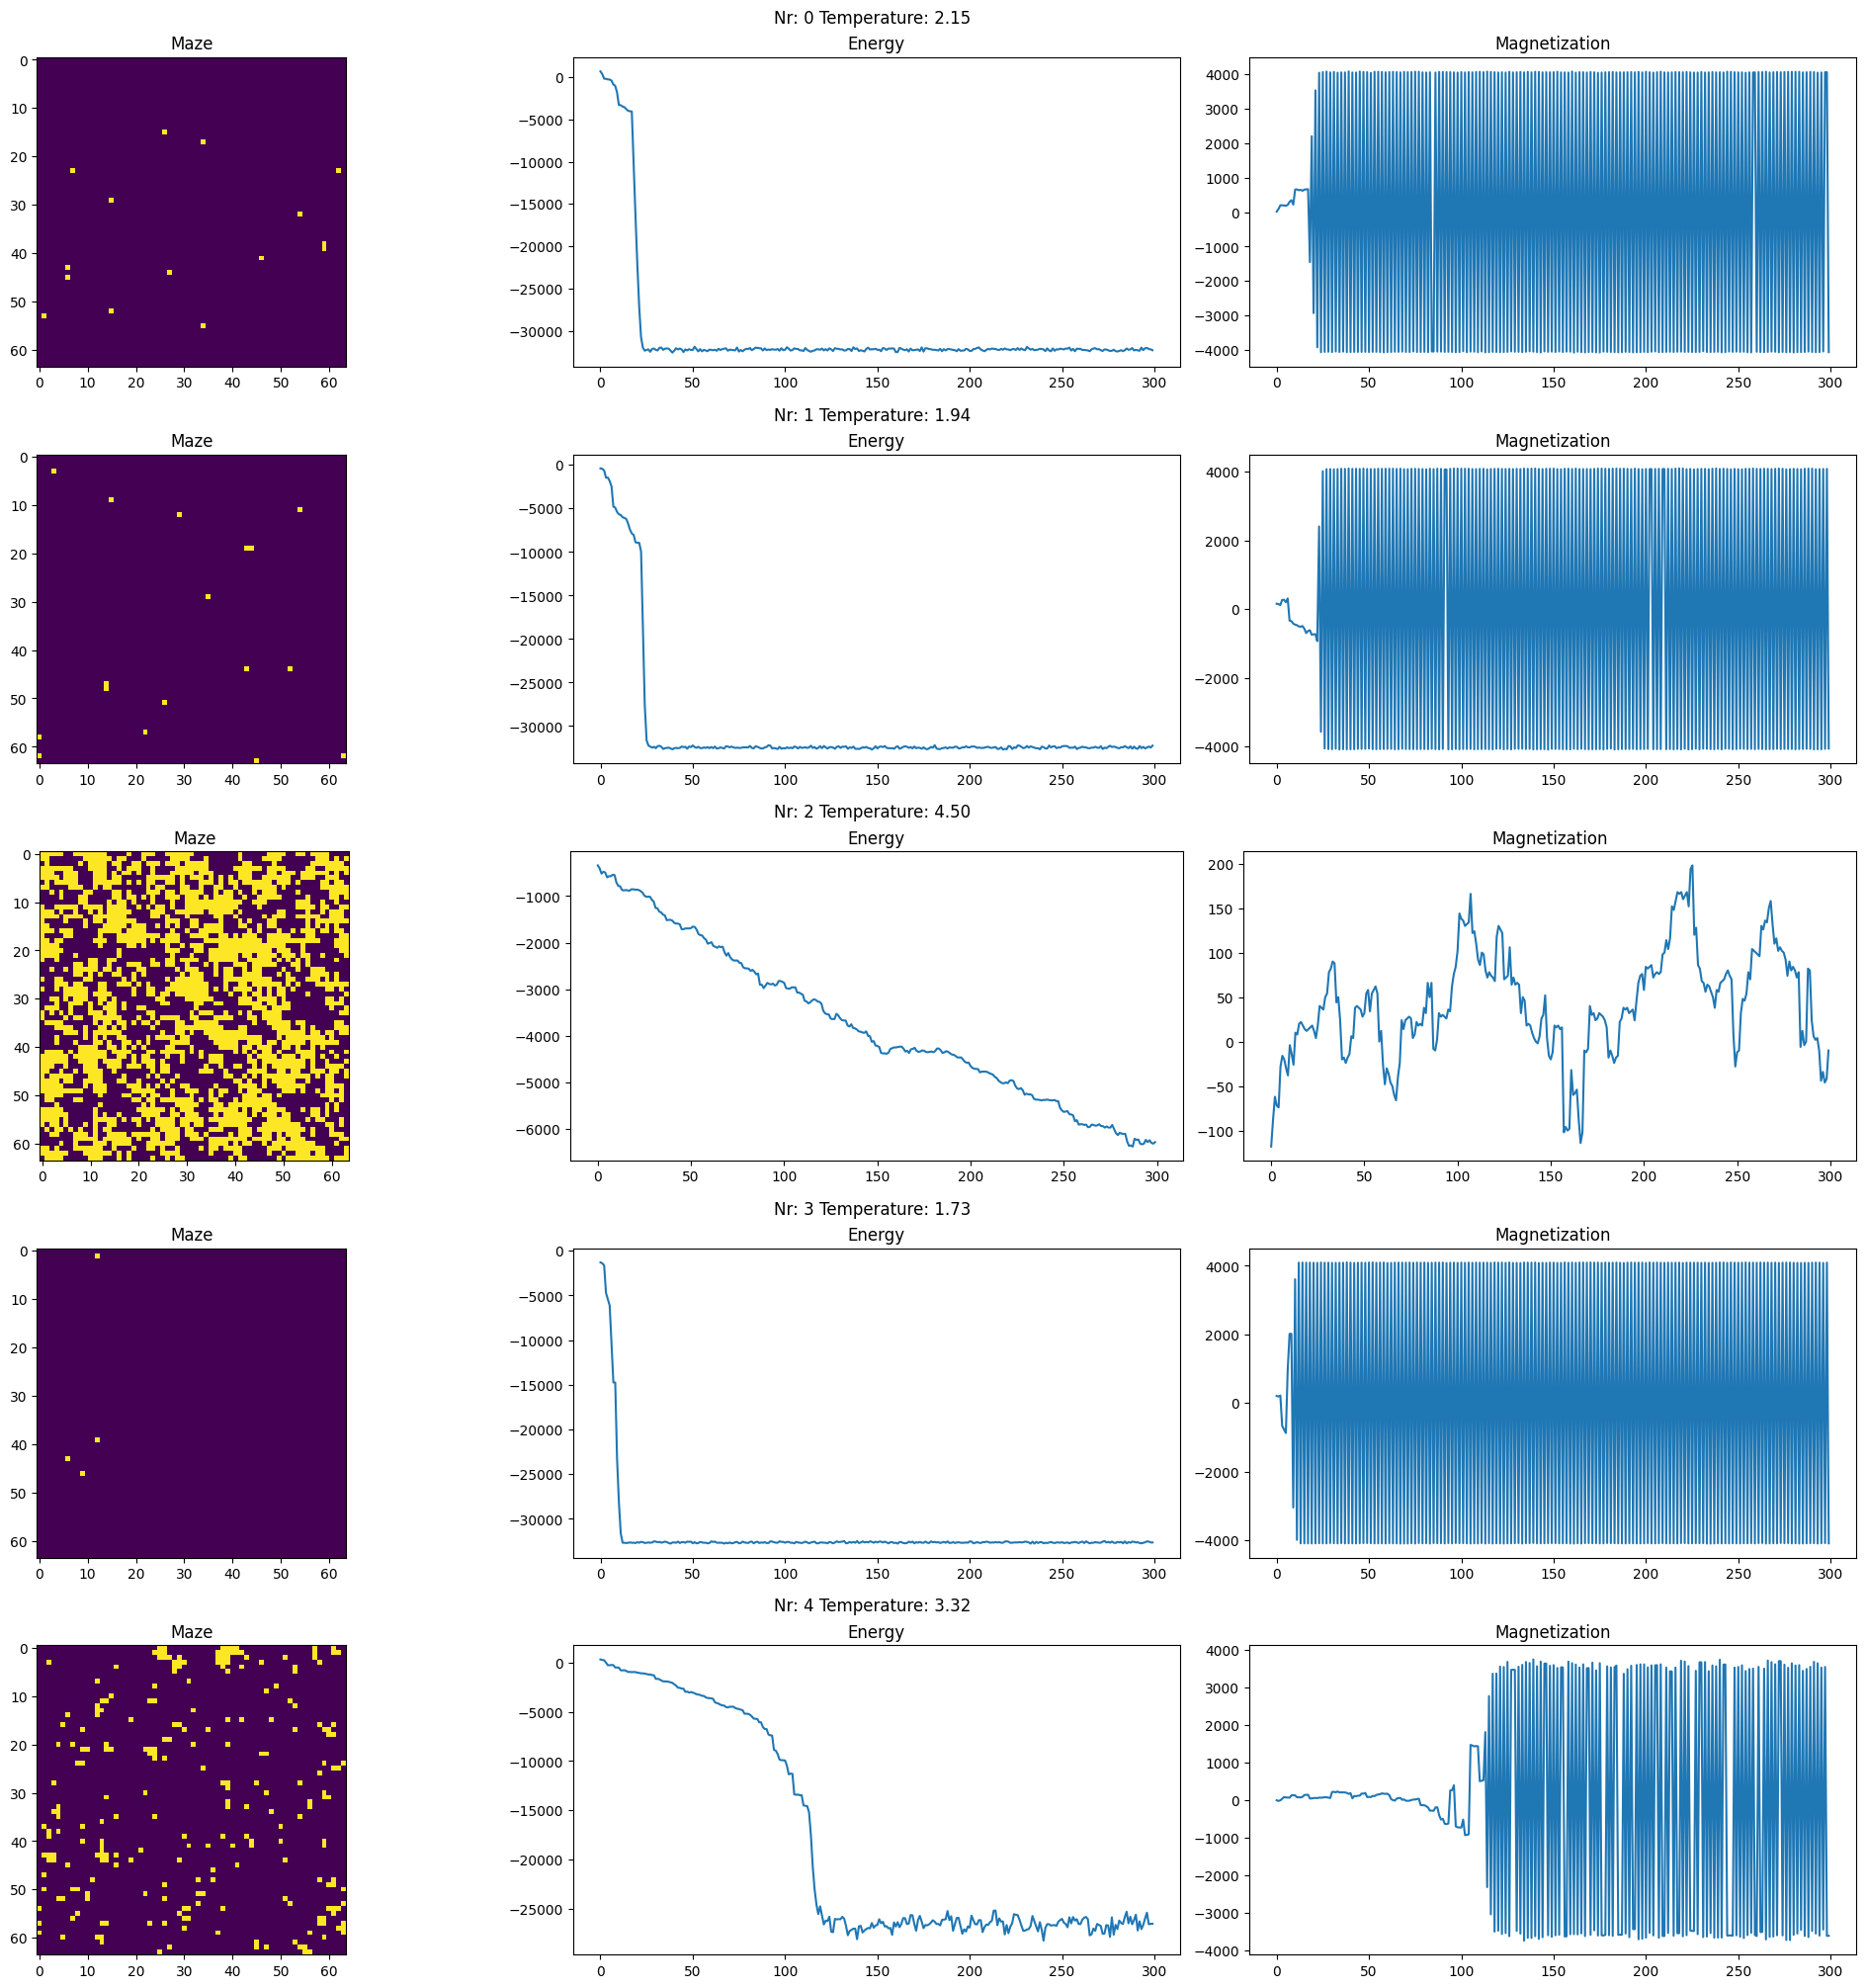

In [12]:
simulate_with_plot(5, simulateWolff)

## Convolutional Layer

Test made for convolutional implementation of function which calculates sum of neighbouring cells. 

<Axes: >

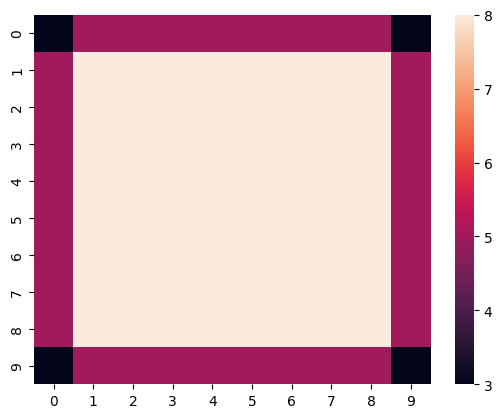

In [13]:
ones = np.ones((10, 10))
results = get_neighbour_sum_matrix_conv(ones)
sns.heatmap(results)

# Time of the simulation

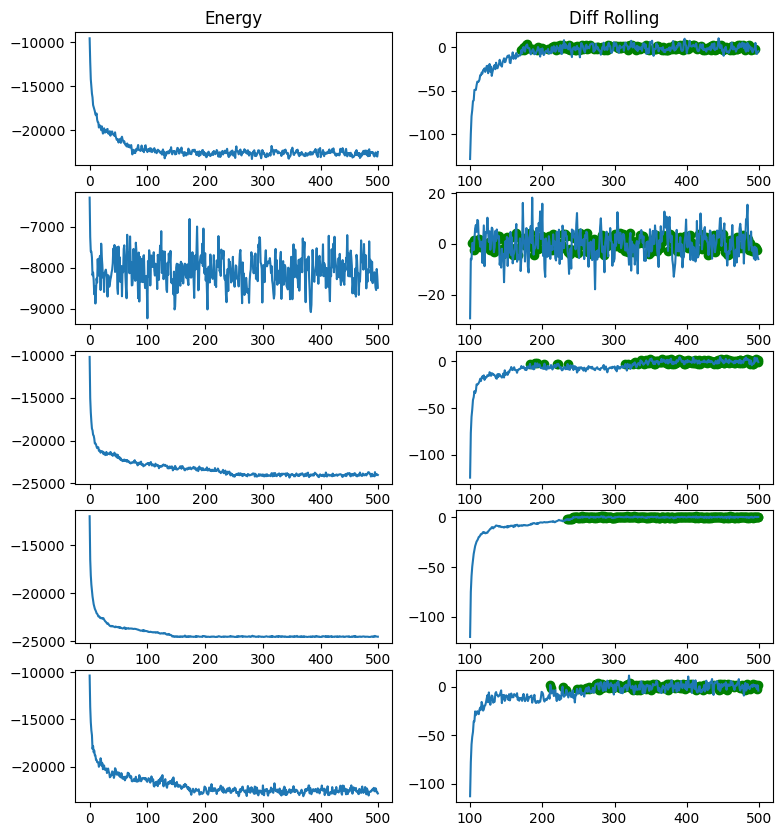

In [14]:
import os
import random

simulations  = []
for root, dir, files in os.walk("Rust/Demo"):

    if 'parameters.csv' in files:
        reader = csv.DictReader(open( root + "/parameters.csv" ))
        par_dict = next(reader)
        temp = float(par_dict['Temperature']) 
        simulations.append((f"{root}/{random.choice(dir)}", temp))

n_cols = 2
n_rows = len(simulations)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize = (9, n_rows * 2))

plot_columns = ["Energy", "Diff Rolling"]
for ax, col in zip(axes[0], plot_columns):
    ax.set_title(col)

for index, (sim, temp) in enumerate(simulations):
    # Statistics
    columns = ['iter','energy','mag']
    df = pd.read_csv(f"{sim}/data.csv", header=None, names=columns).set_index('iter')

    # Energy plot
    axes[index][0].plot(df.energy)
    
    # Energy plot
    energy_diff = df.energy.diff().rolling(100).mean()
    axes[index][1].plot(energy_diff)
    oscilating_points = energy_diff[energy_diff.abs() < 2.5 * np.log(1+temp)]
    axes[index][1].scatter(oscilating_points.index, oscilating_points, color = 'g')


